In [ ]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
sys.path.append(os.path.abspath("../.."))  #TODO: MAKE THE SRC PACKAGE WORK
from src.training.train import train_autoencoder, train_cellfate
from src.evaluation.evaluate import *
from src.training.loss_functions import *
from src.preprocessing.preprocessing_functions import *
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from src.models import Encoder, Decoder, Discriminator, mlp_classifier, complex_mlp_classifier
from src.utils import *
from tensorflow.keras import layers, Sequential
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

In [3]:
## Load Data

x_train = np.load('../../data/images/train_no_aug_time_norm.npy') 
y_train = np.load('../../data/labels/train_labels.npy')  
x_test = np.load('../../data/images/test_time_norm.npy')
y_test = np.load('../../data/labels/test_labels.npy')

## 20% time point

In [20]:
## Load models
time_point = 2 #20%
x_train_20 = x_train[:, time_point, :, :]
x_test_20 = x_test[:, time_point, :, :]
y_train_20 = y_train
y_test_20 = y_test

config = {
    'seed': 42,
    'latent_dim': 2,
    'GaussianNoise_std': 0.003,
}

img_shape = (x_train_20.shape[1], x_train_20.shape[2], 1)
encoder_20 = Encoder(img_shape=img_shape, latent_dim=config['latent_dim'], num_classes=2, gaussian_noise_std=config['GaussianNoise_std']).model
decoder_20 = Decoder(latent_dim=config['latent_dim'], img_shape=img_shape, gaussian_noise_std=config['GaussianNoise_std']).model
encoder_20.load_weights("/Users/inescunha/Documents/GitHub/AI4CellFate/results/temporal_study_tps2_s1_ep35_lr5_la1_seed44_ldim2_s2_lr6_la4_lc1_lcon8/models/encoder.weights.h5") ###TODO: change to the model path
decoder_20.load_weights("/Users/inescunha/Documents/GitHub/AI4CellFate/results/temporal_study_tps2_s1_ep35_lr5_la1_seed44_ldim2_s2_lr6_la4_lc1_lcon8/models/decoder.weights.h5") ###TODO: change to the model path


In [26]:
latent_space_20 = encoder_20.predict(x_train_20)
cor_vals_20 = [np.corrcoef(np.eye(2)[y_train_20][:, 0], latent_space_20[:, i])[0, 1] for i in range(latent_space_20.shape[1])]
cor_vals_20 = np.array(cor_vals_20)
print(cor_vals_20)
most_correlated_feat, least_correlated_feat = np.argsort(np.abs(cor_vals))[-2:] 

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[ 0.20125554 -0.40641429]


## 50% time point

In [ ]:
## Load models
time_point = 5 #50%
x_train_50 = x_train[:, time_point, :, :]
x_test_50 = x_test[:, time_point, :, :]
y_train_50 = y_train
y_test_50 = y_test

config = {
    'seed': 42,
    'latent_dim': 2,
    'GaussianNoise_std': 0.003,
}

img_shape = (x_train_50.shape[1], x_train_50.shape[2], 1)
encoder_50 = Encoder(img_shape=img_shape, latent_dim=config['latent_dim'], num_classes=2, gaussian_noise_std=config['GaussianNoise_std']).model
decoder_50 = Decoder(latent_dim=config['latent_dim'], img_shape=img_shape, gaussian_noise_std=config['GaussianNoise_std']).model
encoder_50.load_weights("/Users/inescunha/Documents/GitHub/AI4CellFate/results/temporal_study_tps5_s1_ep35_lr5_la1_seed43_ldim2_s2_lr6_la4_lc1_lcon8/models/encoder.weights.h5") ###TODO: change to the model path
decoder_50.load_weights("/Users/inescunha/Documents/GitHub/AI4CellFate/results/temporal_study_tps5_s1_ep35_lr5_la1_seed43_ldim2_s2_lr6_la4_lc1_lcon8/models/decoder.weights.h5") ###TODO: change to the model path


In [ ]:
latent_space_50 = encoder_50.predict(x_train_50)
cor_vals_50 = [np.corrcoef(np.eye(2)[y_train_50][:, 0], latent_space_50[:, i])[0, 1] for i in range(latent_space_50.shape[1])]
cor_vals_50 = np.array(cor_vals_50)
#feat_0, feat_1 = np.argsort(np.abs(cor_vals))[-2:] 

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [13]:
cor_vals

array([-0.3113021 ,  0.21636072])

(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


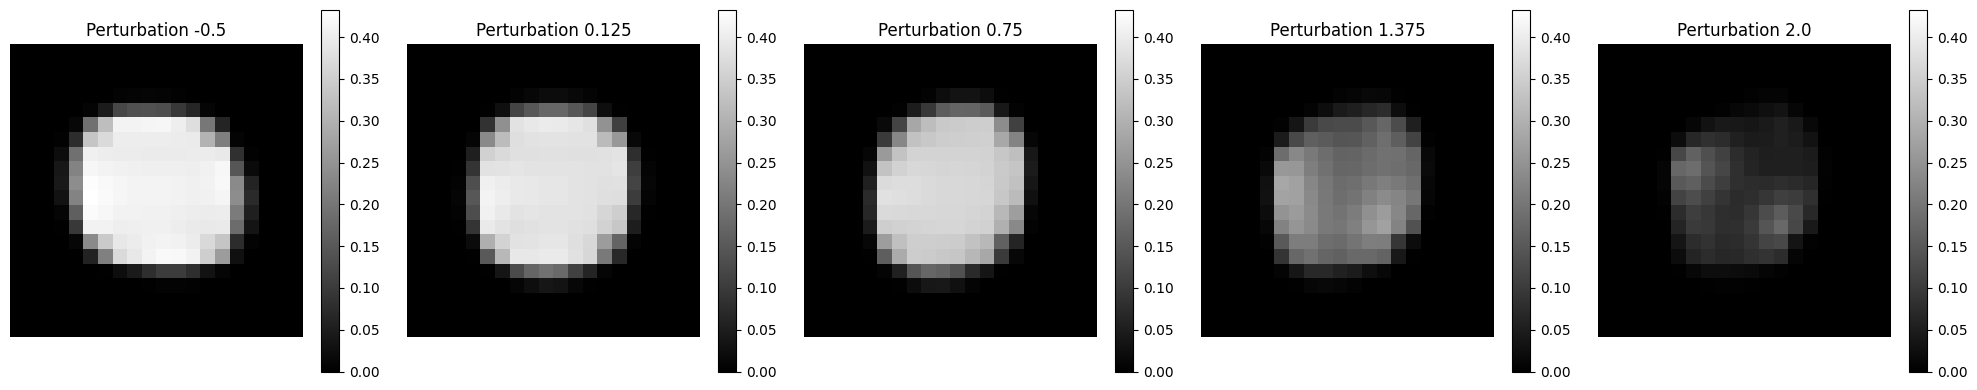

In [ ]:
# Feature 0 - FRET; Feature 1 - Size

baseline_latent_vector = np.zeros((2, 2), dtype=np.float32)  # Start with a neutral latent vector

# Choose the feature to perturb (e.g., feature 0)
feature_index = 0

# Perturbation range
#perturbations = np.linspace(-2, 2, 5) # feature index 1
perturbations = np.linspace(-0.5, 2, 5) # feature index 0

# Store the perturbed reconstructions
perturbed_reconstructions = []

for value in perturbations:
    # Create a copy of the baseline latent vector
    perturbed_vector = baseline_latent_vector.copy()
    print(perturbed_vector.shape)
    # Modify the selected feature
    perturbed_vector[0, feature_index] = value
    
    # Decode the perturbed vector to generate a synthetic image
    synthetic_image = decoder_50.predict(perturbed_vector)  # Assuming 'decoder' is your trained decoder model
    
    # Store the result
    perturbed_reconstructions.append(synthetic_image[0])  # Assuming decoder outputs (batch_size, height, width, channels)

# Convert list to numpy array for easier handling
perturbed_reconstructions = np.array(perturbed_reconstructions)

# Plot the results
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
vmin = perturbed_reconstructions.min()
vmax = perturbed_reconstructions.max()

for i in range(5):
    im = axs[i].imshow(perturbed_reconstructions[i, :, :, 0], cmap='gray', vmin=0.1, vmax=vmax)
    axs[i].set_title(f'Perturbation {perturbations[i]}')
    axs[i].axis('off')
    fig.colorbar(im, ax=axs[i])

plt.tight_layout()
#plt.savefig("perturbations_feat1.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()
